In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dropout, Flatten, Dropout, Dense ,GlobalAveragePooling2D, Concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix , accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import glob 
import pandas as pan
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plotter
from IPython.display import display, HTML
import warnings

In [2]:
image_data='mammals'
pd.DataFrame(os.listdir(image_data),columns=['Files_Name'])

,Files_Name
0,african_elephant
1,alpaca
2,american_bison
3,anteater
4,arctic_fox
5,armadillo
6,baboon
7,badger
8,blue_whale
9,brown_bear


In [3]:
files = [i for i in glob.glob(image_data + "//*//*")]
np.random.shuffle(files)
labels = [os.path.dirname(i).split("/")[-1] for i in files]
data = zip(files, labels)
dataframe = pd.DataFrame(data, columns = ["Image", "Label"])
dataframe

,Image,Label
0,mammals\manatee\manatee-0049.jpg,mammals\manatee
1,mammals\dolphin\dolphin-0108.jpg,mammals\dolphin
2,mammals\opossum\opossum-0282.jpg,mammals\opossum
3,mammals\armadillo\armadillo-0156.jpg,mammals\armadillo
4,mammals\otter\otter-0329.jpg,mammals\otter
...,...,...
13746,mammals\vicuna\vicuna-0042.jpg,mammals\vicuna
13747,mammals\african_elephant\african_elephant-0177...,mammals\african_elephant
13748,mammals\wombat\wombat-0206.jpg,mammals\wombat
13749,mammals\blue_whale\blue_whale-0090.jpg,mammals\blue_whale


C:\Users\Akash\AppData\Local\Temp\ipykernel_24940\2977010320.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataframe["Label"], order=sorted_data, palette=palette)


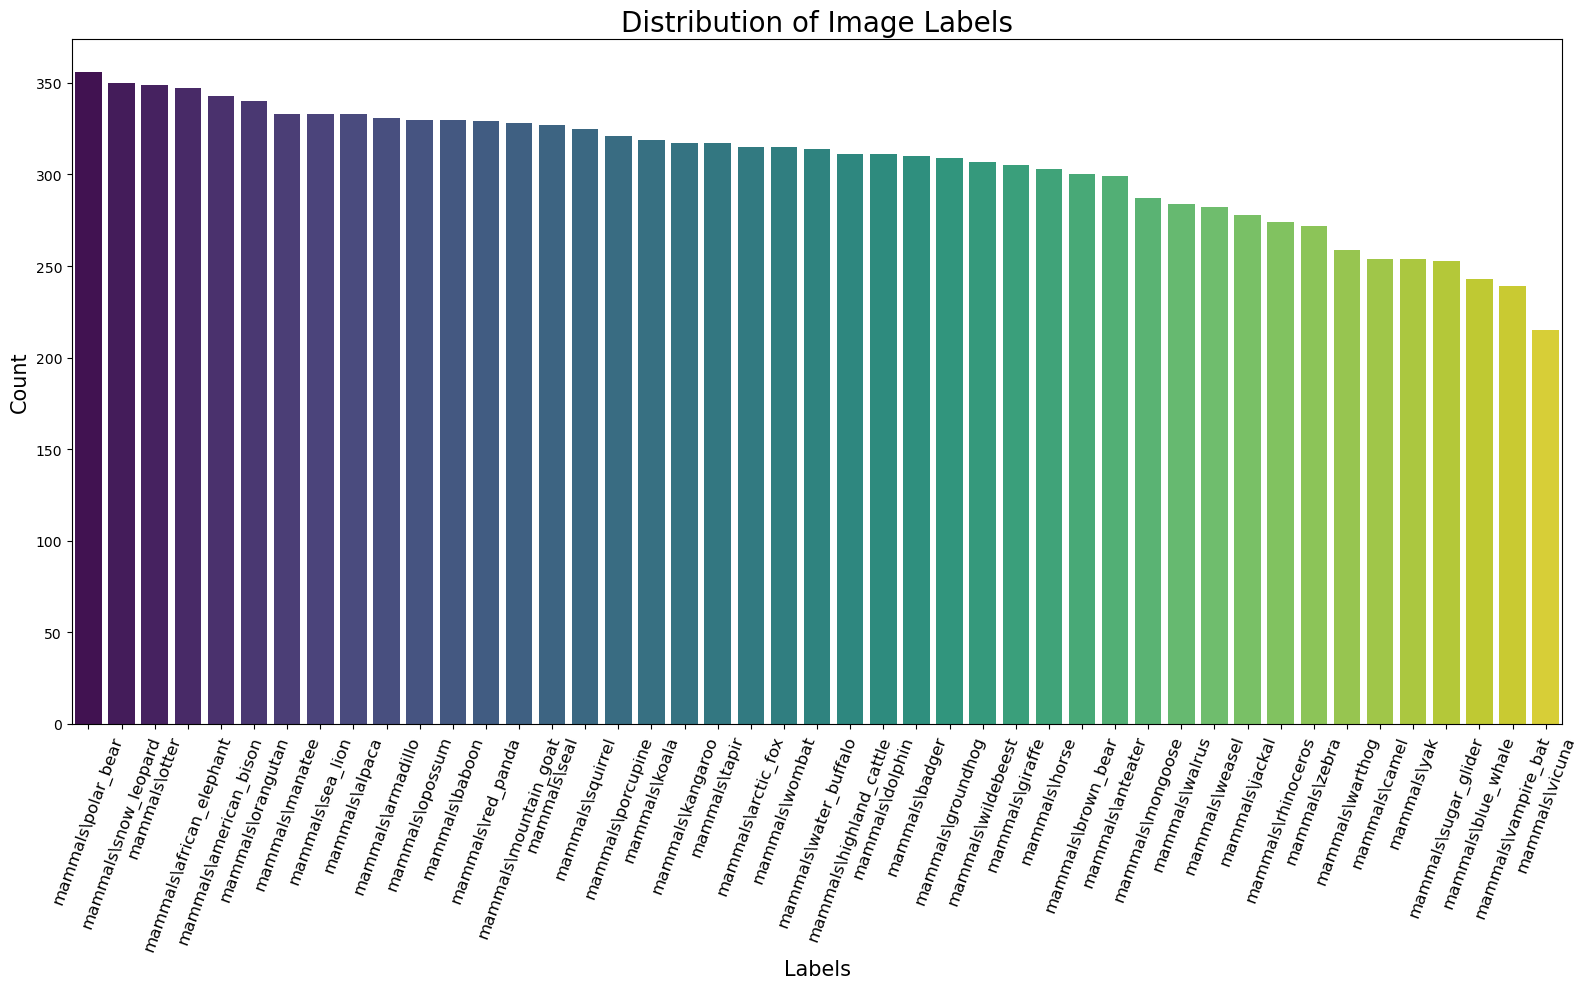

In [56]:
count_data = dataframe["Label"].value_counts()
sorted_data = count_data.sort_values(ascending=False).index
plt.figure(figsize=(16, 10))

palette = sns.color_palette("viridis", len(sorted_data))

sns.countplot(x=dataframe["Label"], order=sorted_data, palette=palette)

plt.title('Distribution of Image Labels', fontsize=20)
plt.xlabel('Labels', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(rotation=70, fontsize=12)
plt.tight_layout()
plt.show()

In [40]:
#params
train_data_dir =image_data
batch_size = 64
target_size = (224,224)
validation_split = 0.2


#both datasets loaded in
train= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="training",
    seed=100,
    image_size=target_size,
    batch_size=batch_size,
)
validation= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=100,
    image_size=target_size,
    batch_size=batch_size,
)


# Function to calculate dataset size
def get_dataset_size(dataset):
    return sum([len(batch[0]) for batch in dataset])

train_size = get_dataset_size(train)
validation_size = get_dataset_size(validation)

Found 13751 files belonging to 45 classes.
Using 11001 files for training.
Found 13751 files belonging to 45 classes.
Using 2750 files for validation.


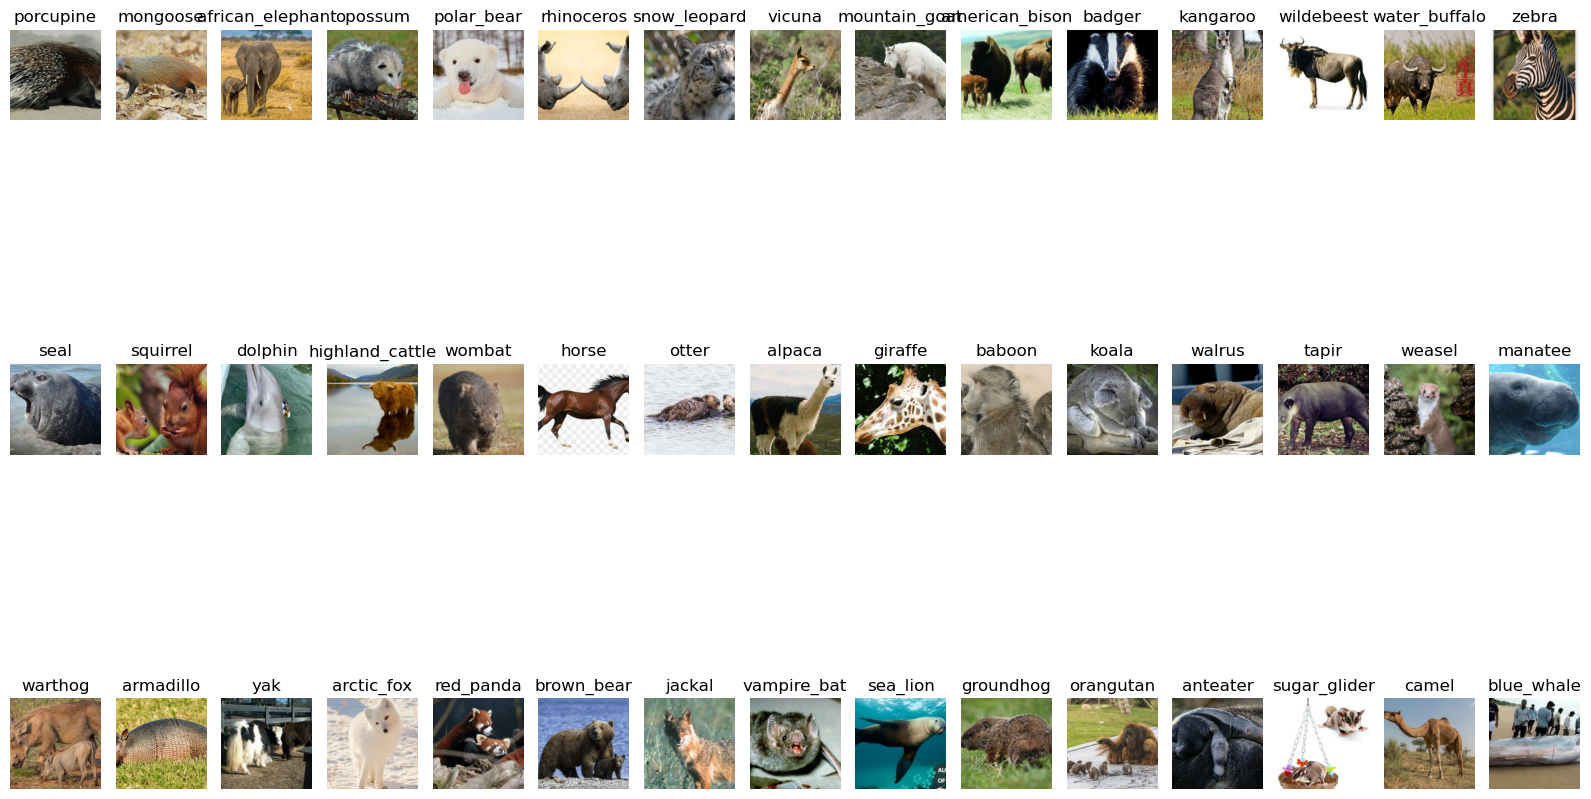

In [66]:
#Setting up images layout and matches labels
class_labels = train.class_names
plt.figure(figsize=(16, len(class_labels) // 15 * 4))
displayed_classes = set()

#training batch selection???
for images, labels in train:
    
    for i in range(len(labels)):
        class_name = class_labels[labels[i]]
        
        if class_name not in displayed_classes:
            ax = plt.subplot((len(class_labels) + 4) // 15, 15, len(displayed_classes) + 1)  # Set 5 images per row
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_name)
            plt.axis("off")
            displayed_classes.add(class_name)
        
        if len(displayed_classes) == len(class_labels):
            break
    if len(displayed_classes) == len(class_labels):
        break

plt.tight_layout()
plt.show()


In [7]:
#mobilenetv3 model
base_model = tf.keras.applications.MobileNetV3Small(input_shape=(224,224,3),include_top=False,weights='imagenet')
base_model.trainable = False  

#keras model additions
model=keras.models.Sequential()
model.add(base_model)
model.add(keras.layers.Flatten()) 
model.add(Dense(256, activation='relu'))  
model.add(keras.layers.Dropout(0.5))
model.add(Dense(len(class_labels), activation='softmax'))
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28224)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     7,225,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 45)             │        11,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,176,285 (31.19 MB)

 Trainable params: 7,237,165 (27.61 MB)

 Non-trainable params: 939,120 (3.58 MB)

In [8]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)

early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

In [12]:
model.compile(
    optimizer='Adam',  
    loss='sparse_categorical_crossentropy',  
    metrics=['accuracy']  
)

#model training
hist = model.fit(
    train,  
    epochs=40,
    validation_data=validation, 
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/40
172/172 ━━━━━━━━━━━━━━━━━━━━ 71s 370ms/step - accuracy: 0.1756 - loss: 3.9969 - val_accuracy: 0.5378 - val_loss: 1.8218 - learning_rate: 0.0010
Epoch 2/40
172/172 ━━━━━━━━━━━━━━━━━━━━ 59s 346ms/step - accuracy: 0.4417 - loss: 2.1435 - val_accuracy: 0.6495 - val_loss: 1.3446 - learning_rate: 0.0010
Epoch 3/40
172/172 ━━━━━━━━━━━━━━━━━━━━ 60s 349ms/step - accuracy: 0.5087 - loss: 1.8098 - val_accuracy: 0.6811 - val_loss: 1.1805 - learning_rate: 0.0010
Epoch 4/40
172/172 ━━━━━━━━━━━━━━━━━━━━ 61s 356ms/step - accuracy: 0.5702 - loss: 1.5217 - val_accuracy: 0.7062 - val_loss: 1.0929 - learning_rate: 0.0010
Epoch 5/40
172/172 ━━━━━━━━━━━━━━━━━━━━ 62s 361ms/step - accuracy: 0.6050 - loss: 1.4077 - val_accuracy: 0.7204 - val_loss: 1.0524 - learning_rate: 0.0010
Epoch 6/40
172/172 ━━━━━━━━━━━━━━━━━━━━ 62s 358ms/step - accuracy: 0.6425 - loss: 1.2496 - val_accuracy: 0.7338 - val_loss: 1.0258 - learning_rate: 0.0010
Epoch 7/40
172/172 ━━━━━━━━━━━━━━━━━━━━ 62s 359ms/step - accuracy: 0.6

In [14]:
#defining classes for ensemble?
input_shape = (224, 224, 3)
num_classes = 45

#models for the original mobilenet and the two most efficient keras models for time
base_model_1 = tf.keras.applications.MobileNetV3Small(input_shape=input_shape, include_top=False, weights='imagenet')
base_model_2 = tf.keras.applications.EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')
base_model_3 = tf.keras.applications.ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')

base_model_1.trainable = False
base_model_2.trainable = False
base_model_3.trainable = False

#branching
def create_branch(base_model):
    branch_model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),  #Using GlobalAveragePooling2D instead of Flatten
        Dropout(0.5)
    ])
    return branch_model

branch_1 = create_branch(base_model_1)
branch_2 = create_branch(base_model_2)
branch_3 = create_branch(base_model_3)

#model input
input_layer = keras.Input(shape=input_shape)
output_1 = branch_1(input_layer)
output_2 = branch_2(input_layer)
output_3 = branch_3(input_layer)
merged = Concatenate()([output_1, output_2, output_3])

#added layers
x = Dense(256, activation='relu')(merged)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

ensemble_model = Model(inputs=input_layer, outputs=output_layer)

ensemble_model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 576)       │    939,120 │ input_layer_8[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 1280)      │  4,049,571 │ input_layer_8[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 2048)      │ 23,587,712 │ input_layer_8[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 3904)      │          0 │ sequential_1[0][… │
│ (Concatenate)       │                   │            │ sequential_2[0][… │
│                     │                   │            │ sequential_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    999,680 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 45)        │     11,565 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 29,587,648 (112.87 MB)

 Trainable params: 1,011,245 (3.86 MB)

 Non-trainable params: 28,576,403 (109.01 MB)

In [20]:
# Define callbacks for the model
checkpoint = ModelCheckpoint("ensemble_model.keras", save_best_only=True )

early_stopping = EarlyStopping(patience=5, restore_best_weights=True )


In [22]:
# Compile the model
ensemble_model.compile(
    optimizer='Adam', 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the ensemble model
hist_re = ensemble_model.fit(
    train,  
    epochs=35,  
    validation_data=validation, 
    callbacks=[checkpoint, early_stopping]  
)


Epoch 1/35
172/172 ━━━━━━━━━━━━━━━━━━━━ 656s 4s/step - accuracy: 0.4154 - loss: 2.3553 - val_accuracy: 0.9062 - val_loss: 0.3229
Epoch 2/35
172/172 ━━━━━━━━━━━━━━━━━━━━ 596s 3s/step - accuracy: 0.8180 - loss: 0.6034 - val_accuracy: 0.9262 - val_loss: 0.2472
Epoch 3/35
172/172 ━━━━━━━━━━━━━━━━━━━━ 576s 3s/step - accuracy: 0.8690 - loss: 0.4310 - val_accuracy: 0.9367 - val_loss: 0.2284
Epoch 4/35
172/172 ━━━━━━━━━━━━━━━━━━━━ 573s 3s/step - accuracy: 0.8946 - loss: 0.3493 - val_accuracy: 0.9393 - val_loss: 0.2161
Epoch 5/35
172/172 ━━━━━━━━━━━━━━━━━━━━ 580s 3s/step - accuracy: 0.8982 - loss: 0.3151 - val_accuracy: 0.9462 - val_loss: 0.1882
Epoch 6/35
172/172 ━━━━━━━━━━━━━━━━━━━━ 575s 3s/step - accuracy: 0.9157 - loss: 0.2828 - val_accuracy: 0.9444 - val_loss: 0.1953
Epoch 7/35
172/172 ━━━━━━━━━━━━━━━━━━━━ 580s 3s/step - accuracy: 0.9191 - loss: 0.2651 - val_accuracy: 0.9422 - val_loss: 0.1905
Epoch 8/35
172/172 ━━━━━━━━━━━━━━━━━━━━ 569s 3s/step - accuracy: 0.9303 - loss: 0.2242 - val_accu

In [24]:
hist_keras_model = pd.DataFrame(hist.history)

print(hist_keras_model.head(2).to_string(index=False))
print("...")
print(hist_keras_model.tail(2).to_string(index=False))

 accuracy     loss  val_accuracy  val_loss  learning_rate
 0.252432 3.160430      0.537818  1.821813          0.001
 0.448141 2.102069      0.649455  1.344634          0.001
...
 accuracy     loss  val_accuracy  val_loss  learning_rate
 0.747296 0.828076      0.763273  1.054168          0.001
 0.753295 0.818510      0.760727  1.083640          0.001


In [26]:
hist_ensemble_model=pd.DataFrame(hist_re.history)

print(hist_ensemble_model.head(2).to_string(index=False))
print("...")
print(hist_ensemble_model.tail(2).to_string(index=False))

 accuracy     loss  val_accuracy  val_loss
 0.611399 1.449615      0.906182  0.322917
 0.832833 0.557050      0.926182  0.247184
...
 accuracy     loss  val_accuracy  val_loss
 0.931279 0.212854      0.940000  0.203915
 0.934642 0.200145      0.947273  0.193213


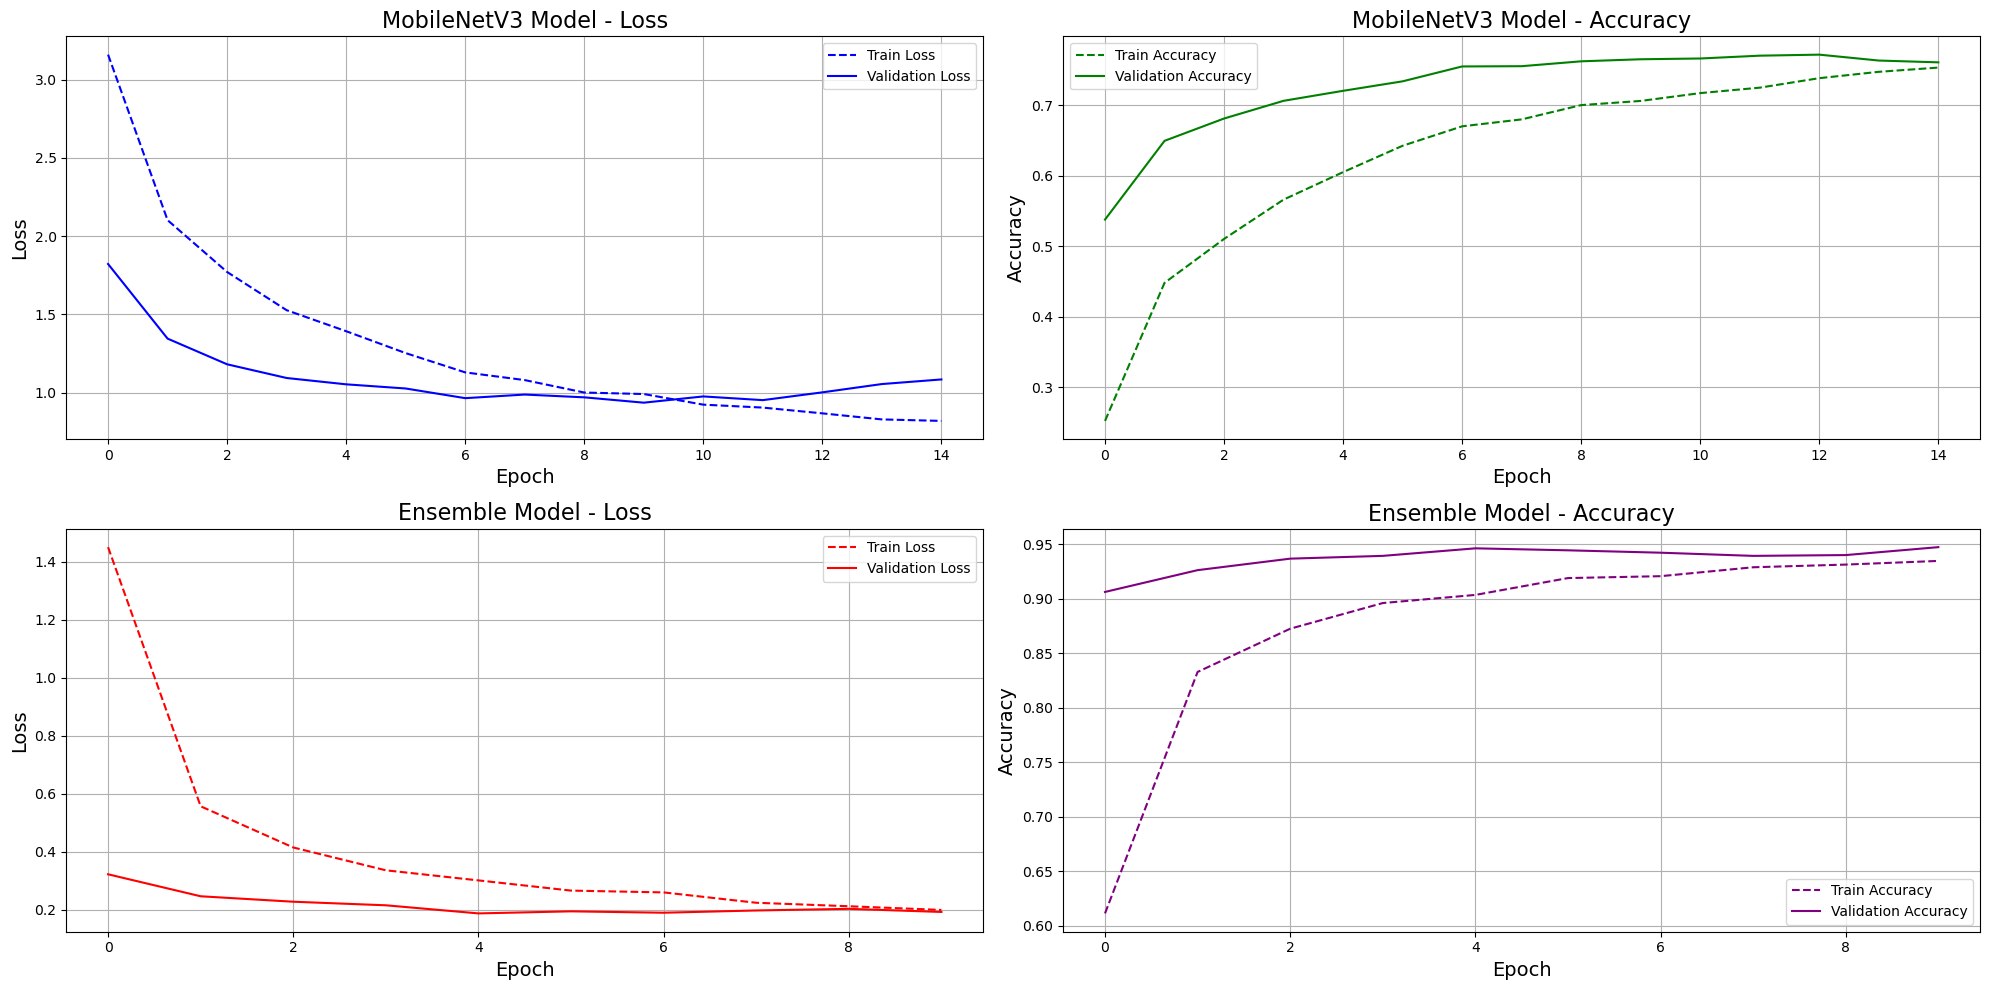

43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 243ms/step - accuracy: 0.7639 - loss: 0.9180
43/43 ━━━━━━━━━━━━━━━━━━━━ 114s 3s/step - accuracy: 0.9500 - loss: 0.1856


Model,Validation Loss,Validation Accuracy
MobileNetV3 Model,0.935084,0.765091
Ensemble Model,0.188179,0.946182


In [28]:
plt.figure(figsize=(20, 10))
#loss for Keras model
plt.subplot(2, 2, 1)
plt.plot(hist.history['loss'], label='Train Loss', color='blue', linestyle='--')
plt.plot(hist.history['val_loss'], label='Validation Loss', color='blue')
plt.title('MobileNetV3 Model - Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.grid(True)

#accuracy for Keras model
plt.subplot(2, 2, 2)
plt.plot(hist.history['accuracy'], label='Train Accuracy', color='green', linestyle='--')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy', color='green')
plt.title('MobileNetV3 Model - Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend()
plt.grid(True)

#loss for Ensemble model
plt.subplot(2, 2, 3)
plt.plot(hist_re.history['loss'], label='Train Loss', color='red', linestyle='--')
plt.plot(hist_re.history['val_loss'], label='Validation Loss', color='red')
plt.title('Ensemble Model - Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.grid(True)

#accuracy for Ensemble model
plt.subplot(2, 2, 4)
plt.plot(hist_re.history['accuracy'], label='Train Accuracy', color='purple', linestyle='--')
plt.plot(hist_re.history['val_accuracy'], label='Validation Accuracy', color='purple')
plt.title('Ensemble Model - Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend()
plt.grid(True)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

# Evaluate and display validation performance for both models
score_keras, acc_keras = model.evaluate(validation)
score_ensemble, acc_ensemble = ensemble_model.evaluate(validation)

# Create a DataFrame to display results nicely
results_df = pd.DataFrame({
    'Model': ['MobileNetV3 Model', 'Ensemble Model'],
    'Validation Loss': [score_keras, score_ensemble],
    'Validation Accuracy': [acc_keras, acc_ensemble]
})

# Display the results in a table
display(HTML(results_df.to_html(index=False)))

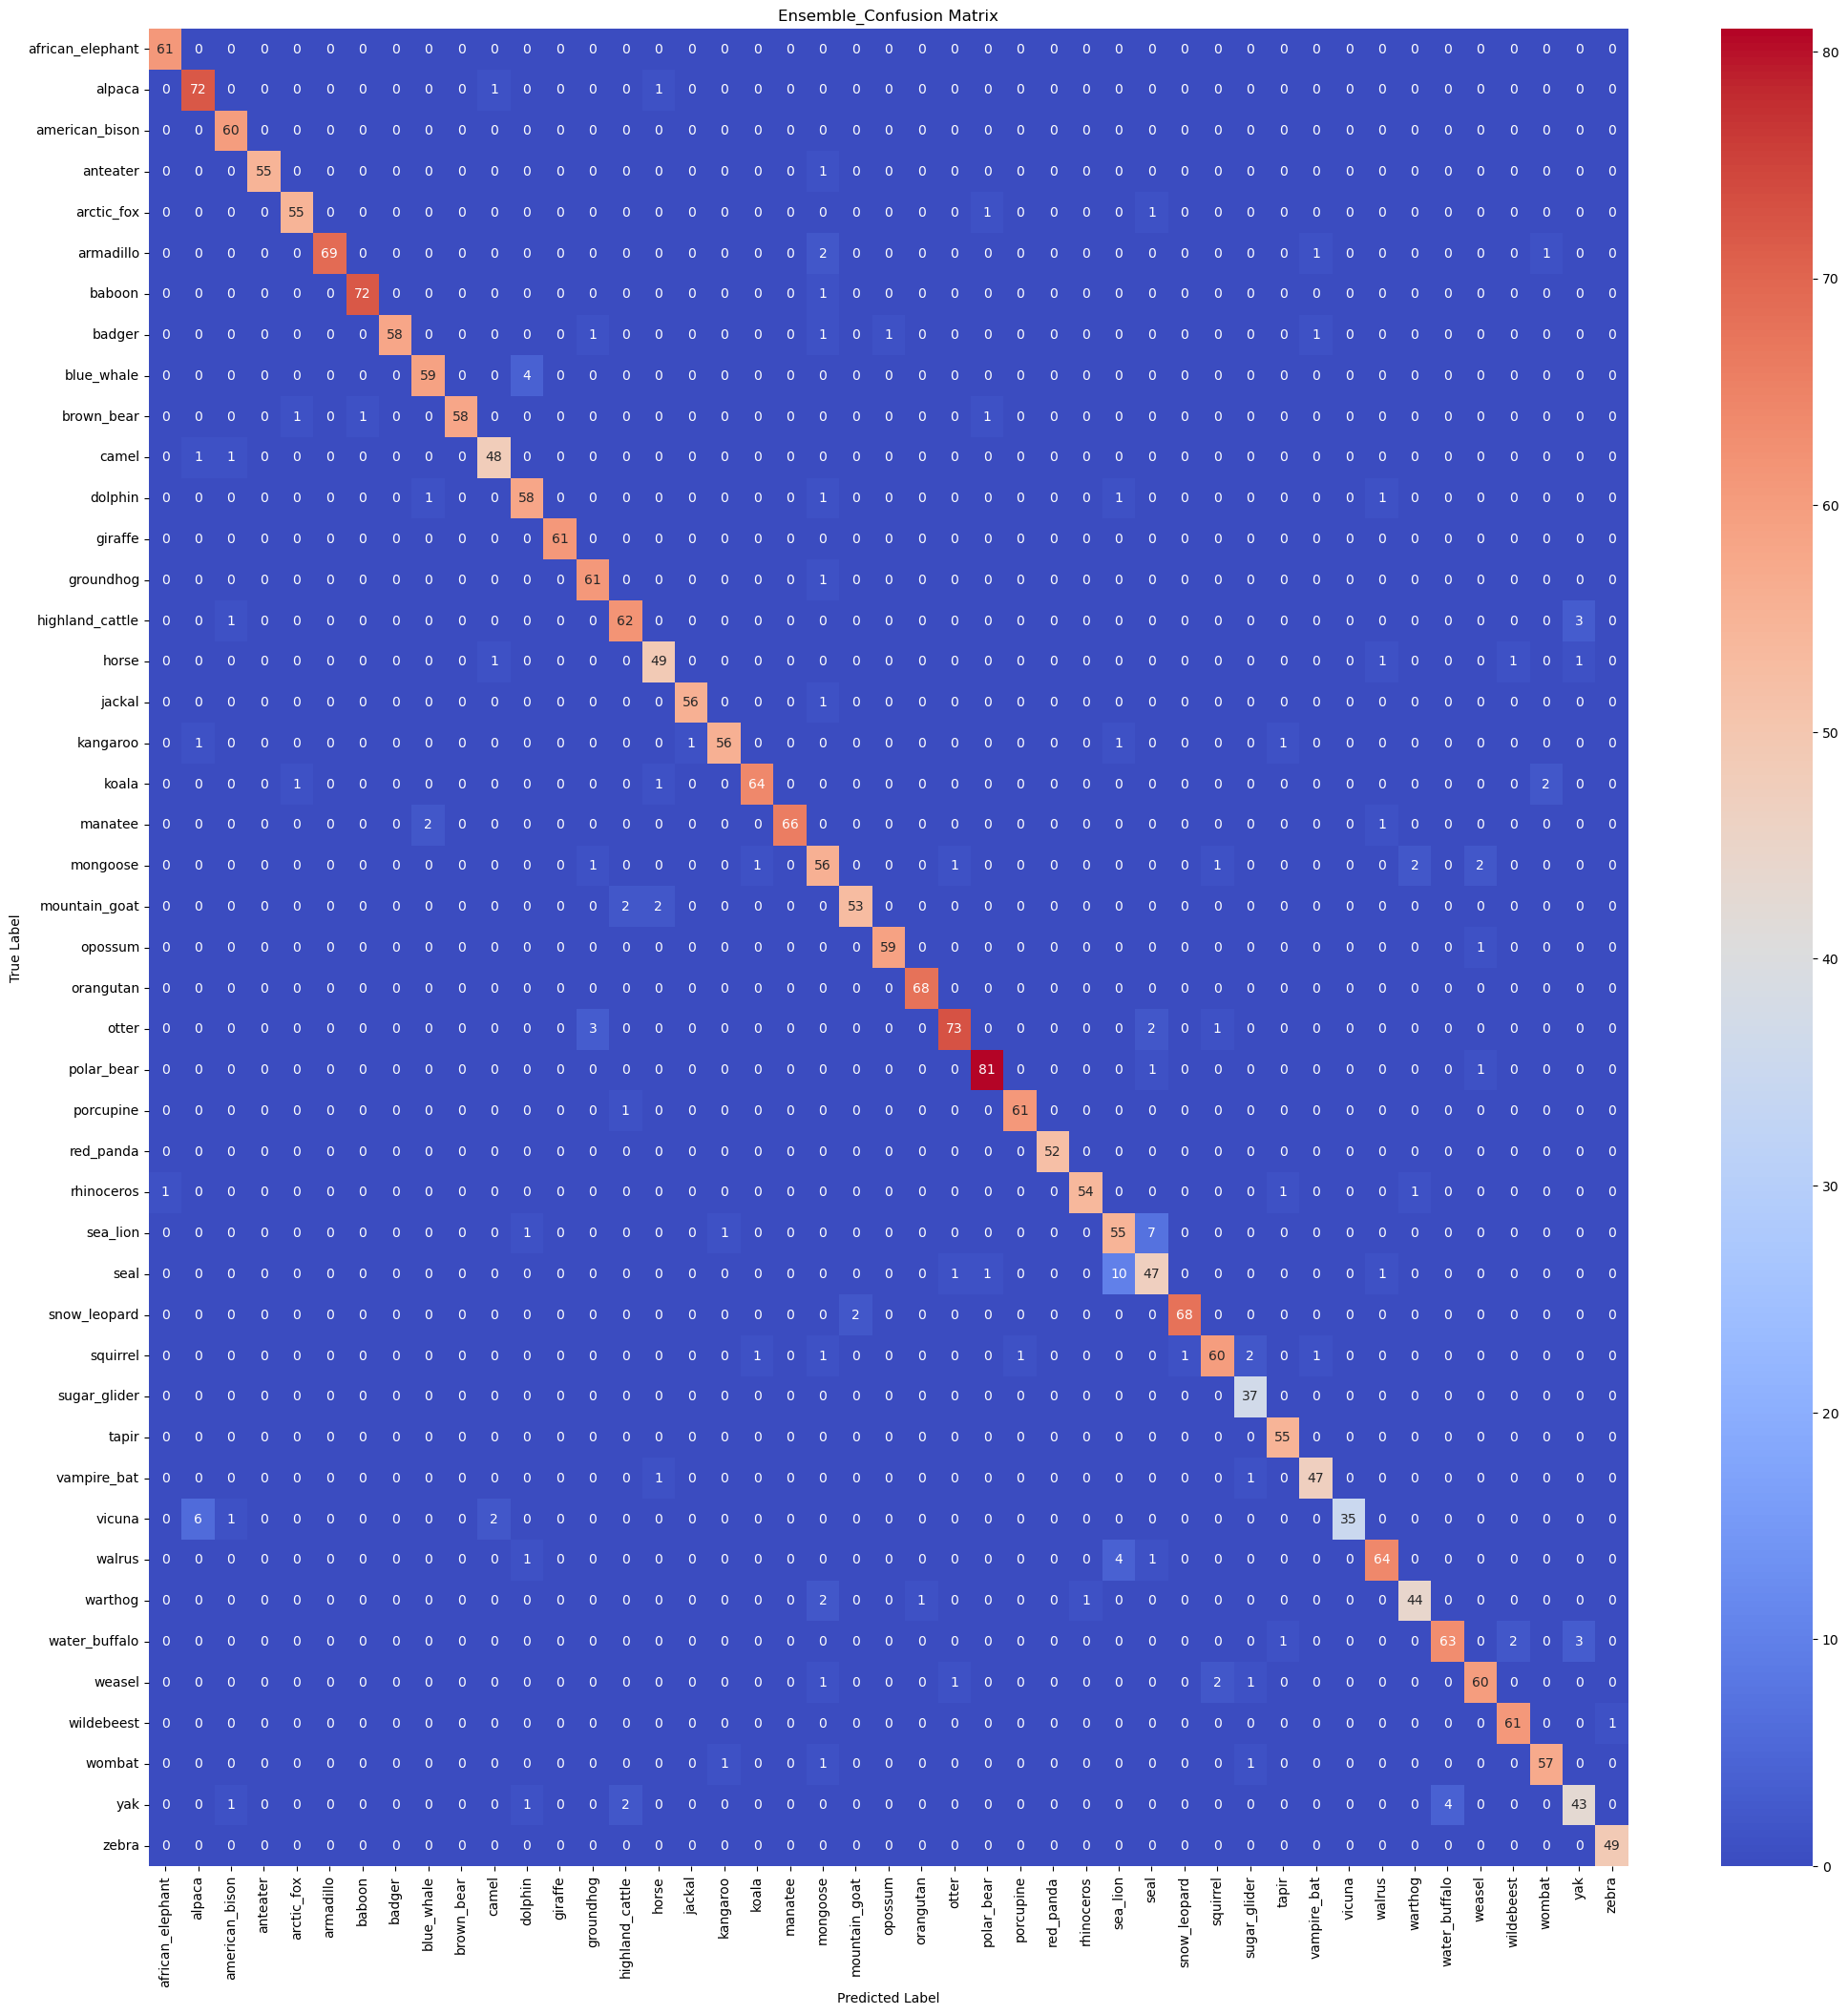

In [58]:
# Function to get true and predicted labels from the dataset
def get_true_and_predicted_labels(model, dataset):
    true_labels = []
    predicted_labels = []
    for img_batch, label_batch in dataset:
        predictions = model.predict(img_batch, verbose=0)
        predicted_labels.extend(np.argmax(predictions, axis=1))
        true_labels.extend(label_batch.numpy())
    
    return np.array(true_labels), np.array(predicted_labels)

# Get true and predicted labels
true_labels, predicted_labels = get_true_and_predicted_labels(ensemble_model, validation)

# Compute confusion matrix with raw counts
ensemble_model_conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix with raw counts
plt.figure(figsize=(25, 25))
sns.heatmap(ensemble_model_conf_matrix, annot=True, fmt='d', cmap='coolwarm', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Ensemble_Confusion Matrix')
plt.show()